In [28]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time-series forecasting
from prophet import Prophet
import statsmodels.api as sm 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [29]:
trains = pd.read_csv("train.csv")

#quick overview
print("Shape:", trains.shape)
trains.head() 

Shape: (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [30]:
#basic dataset inspection
trains.info()

#checking for missing values
print("\nMissing values per column:\n", trains.isna().sum())

#checking date range
print("\nDate range:", trains['date'].min(), "to", trains['date'].max())

#summary stats
trains.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB

Missing values per column:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Date range: 2013-01-01 to 2017-08-15


,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


C:\Users\hp\AppData\Local\Temp\ipykernel_26976\3622830661.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_store['date'] = pd.to_datetime(sample_store['date'])


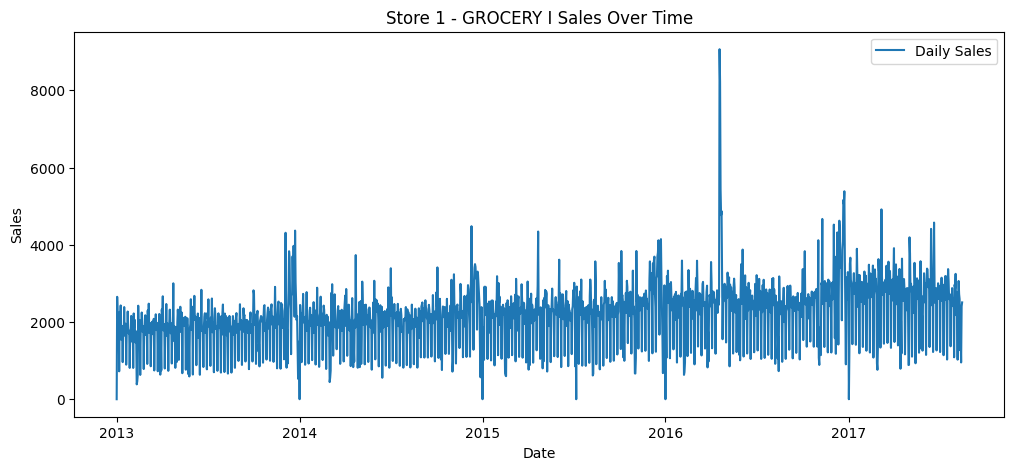

In [31]:
#focusing on one store and one product family for clarity
sample_store = trains[(trains['store_nbr'] == 1) & (trains['family'] == 'GROCERY I')]

#converting date to datetime
sample_store['date'] = pd.to_datetime(sample_store['date'])
sample_store = sample_store.sort_values('date')

#plot
plt.figure(figsize=(12,5))
plt.plot(sample_store['date'], sample_store['sales'], label='Daily Sales')
plt.title("Store 1 - GROCERY I Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [32]:
#data cleaning and feature engineering
#checking missing values again
print("Missing values per column:\n", trains.isna().sum())

#dropping rows with missing sales or dates
trains.dropna(subset=['sales', 'date'], inplace=True)

#filling missing promotion data with 0 (if any)
trains['onpromotion'] = trains['onpromotion'].fillna(0)

print("After cleaning:", trains.shape) 

Missing values per column:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
After cleaning: (3000888, 6)


In [33]:
trains['date'] = pd.to_datetime(trains['date'])
trains = trains.sort_values('date') 

In [34]:
#creating additional time features
trains['year'] = trains['date'].dt.year
trains['month'] = trains['date'].dt.month
trains['day'] = trains['date'].dt.day
trains['dayofweek'] = trains['date'].dt.dayofweek
trains['is_weekend'] = trains['dayofweek'].isin([5, 6]).astype(int) 

In [35]:
#aggregating sales (daily level per store)
#focusing on one store-family pair
store_family = trains[(trains['store_nbr'] == 1) & (trains['family'] == 'GROCERY I')]

#aggregating daily sales
daily_sales = store_family.groupby('date')['sales'].sum().reset_index()

#renaming for Prophet
daily_sales.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

daily_sales.head()


,ds,y
0,2013-01-01,0.0
1,2013-01-02,2652.0
2,2013-01-03,2121.0
3,2013-01-04,2056.0
4,2013-01-05,2216.0


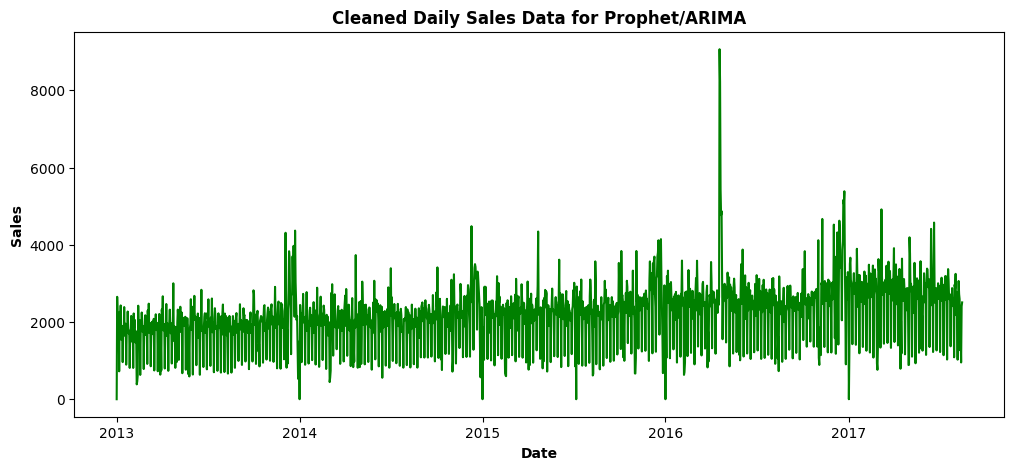

In [36]:
#visual check of clean data
plt.figure(figsize=(12,5))
plt.plot(daily_sales['ds'], daily_sales['y'], color='green')
plt.title("Cleaned Daily Sales Data for Prophet/ARIMA", fontweight='bold')
plt.xlabel("Date", fontweight='bold')
plt.ylabel("Sales",fontweight='bold')
plt.show() 

In [37]:
#model building - prophet, then ARIMA, then full comparison
#prophet forecasting model
#splitting the data
train = daily_sales.iloc[:-90]   # all except last 90 days
test = daily_sales.iloc[-90:]    # last 90 days

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (1594, 2)
Test size: (90, 2)


In [41]:
#training prophet
from prophet import Prophet

prophet_trains = trains[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

#initialising model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

# Fit model
prophet_model.fit(train) 

08:41:00 - cmdstanpy - INFO - Chain [1] start processing
08:41:14 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
#creating future dataframe
future = prophet_model.make_future_dataframe(periods=90)

#generating forecast
forecast = prophet_model.predict(future)

#viewing forecast tail
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() 

,ds,yhat,yhat_lower,yhat_upper
1679,2017-08-11,2691.755995,2038.708888,3247.572100
1680,2017-08-12,2603.750684,1991.484006,3240.825263
1681,2017-08-13,1325.996685,684.837329,1977.397310
1682,2017-08-14,2666.676719,2048.575601,3278.327769
1683,2017-08-15,2697.974424,2098.178908,3297.910845


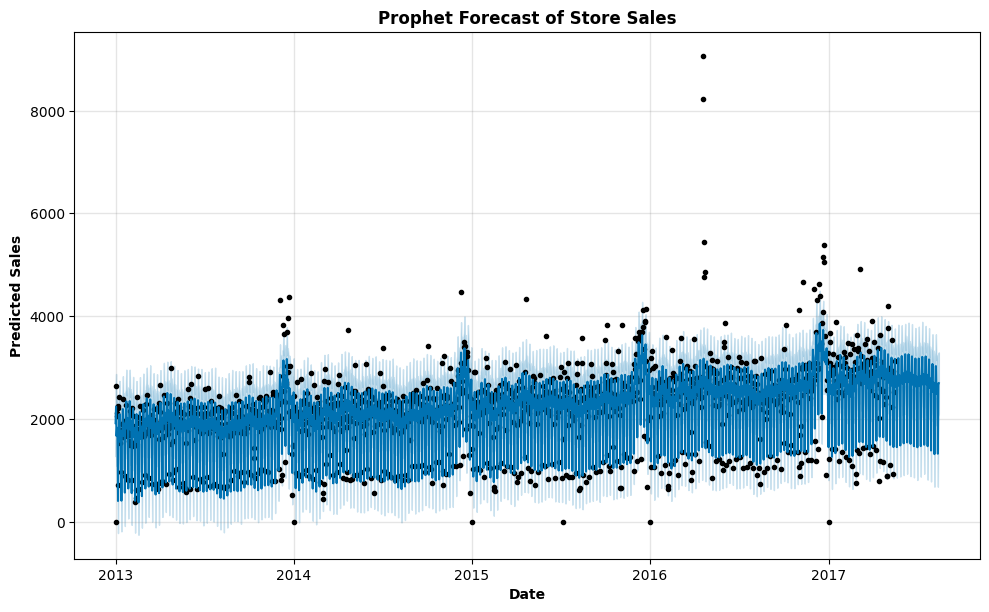

In [43]:
#visualising the prophet forcast
prophet_model.plot(forecast)
plt.title("Prophet Forecast of Store Sales", fontweight='bold')
plt.xlabel("Date", fontweight='bold')
plt.ylabel("Predicted Sales", fontweight='bold')
plt.show() 

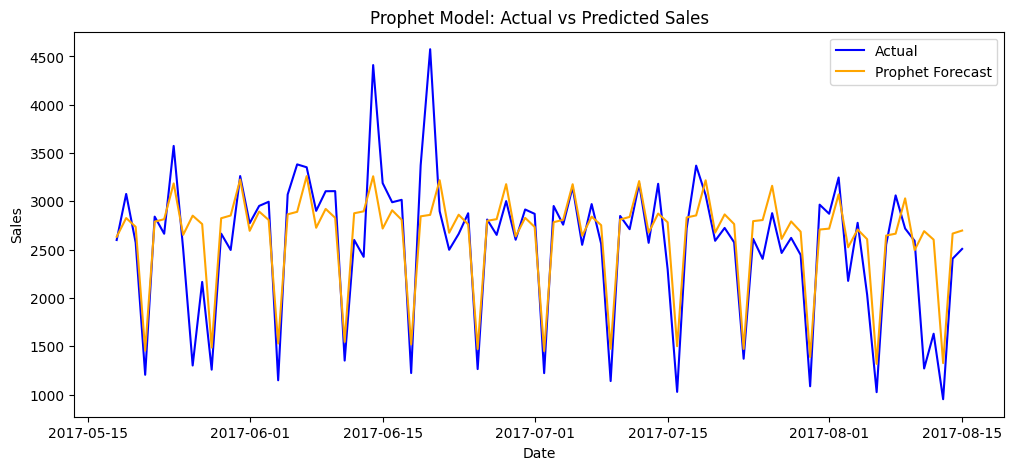

In [44]:
#comparing predictions vs actuals
#merging actual and predicted for test period
prophet_pred = forecast.set_index('ds').loc[test['ds']]
prophet_results = test.copy()
prophet_results['Predicted'] = prophet_pred['yhat'].values

#plotting actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(prophet_results['ds'], prophet_results['y'], label='Actual', color='blue')
plt.plot(prophet_results['ds'], prophet_results['Predicted'], label='Prophet Forecast', color='orange')
plt.title("Prophet Model: Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show() 

In [45]:
#evaluating prophet perfomance
from sklearn.metrics import mean_squared_error, r2_score

mse_prophet = mean_squared_error(prophet_results['y'], prophet_results['Predicted'])
r2_prophet = r2_score(prophet_results['y'], prophet_results['Predicted'])

print(f"Prophet Model → MSE: {mse_prophet:.2f} | R²: {r2_prophet:.3f}") 

Prophet Model → MSE: 170389.26 | R²: 0.680


In [46]:
#training ARIMA (ARIMA requires a stationary series, but I’ll let the model auto-detect the best parameters)
from statsmodels.tsa.arima.model import ARIMA

#using only training data
y_train = train['y']

#fitting ARIMA model
arima_model = ARIMA(y_train, order=(5,1,2))  # (p,d,q)
arima_result = arima_model.fit()

#forecasting next 90 days
forecast_arima = arima_result.forecast(steps=90) 

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


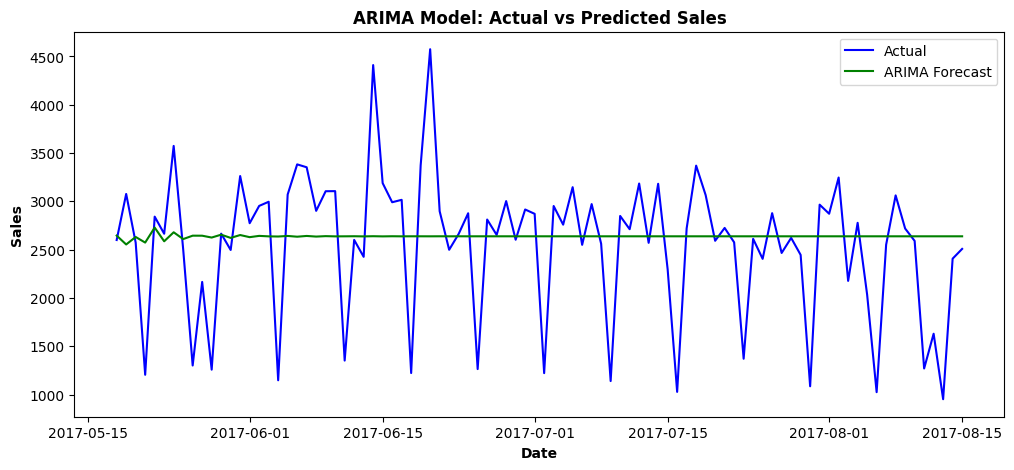

In [47]:
#comparing with actuals
arima_results = test.copy()
arima_results['Predicted'] = forecast_arima.values

plt.figure(figsize=(12,5))
plt.plot(arima_results['ds'], arima_results['y'], label='Actual', color='blue')
plt.plot(arima_results['ds'], arima_results['Predicted'], label='ARIMA Forecast', color='green')
plt.title("ARIMA Model: Actual vs Predicted Sales",fontweight='bold')
plt.xlabel("Date",fontweight='bold')
plt.ylabel("Sales",fontweight='bold')
plt.legend()
plt.show() 

In [48]:
#evaluating ARIMA performance
mse_arima = mean_squared_error(arima_results['y'], arima_results['Predicted'])
r2_arima = r2_score(arima_results['y'], arima_results['Predicted'])

print(f"ARIMA Model → MSE: {mse_arima:.2f} | R²: {r2_arima:.3f}")

ARIMA Model → MSE: 536646.62 | R²: -0.008


In [59]:
#comparing prophet with ARIMA
comparison_trains = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA'],
    'MSE': [mse_prophet, mse_arima],
    'R²': [r2_prophet, r2_arima]
})
print(comparison_trains) 

     Model            MSE        R²
0  Prophet  170389.264763  0.680109
1    ARIMA  536646.621676 -0.007506


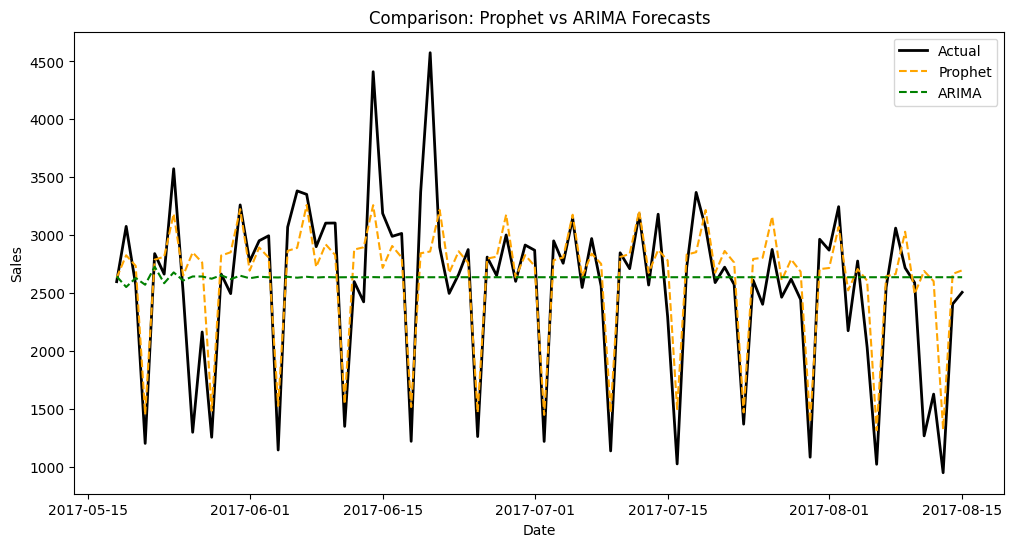

In [60]:
#combined visuals
plt.figure(figsize=(12,6))
plt.plot(test['ds'], test['y'], label='Actual', color='black', linewidth=2)
plt.plot(prophet_results['ds'], prophet_results['Predicted'], label='Prophet', color='orange', linestyle='--')
plt.plot(arima_results['ds'], arima_results['Predicted'], label='ARIMA', color='green', linestyle='--')
plt.title("Comparison: Prophet vs ARIMA Forecasts")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show() 

In [55]:
import joblib

#saving Prophet and ARIMA models
joblib.dump(prophet_model, "prophet_model.pkl")
joblib.dump(arima_result, "arima_model.pkl")

print("Models saved successfully!") 

Models saved successfully!


In [57]:
import os

print(os.listdir())


['arima_model.pkl', 'prophet_model.pkl', 'requirements.txt', 'train.csv', 'trains.ipynb', 'trains.py']
